In [16]:
import yfinance as yf
import pandas as pd
import os

In [17]:

sp500 = pd.read_excel('test_prices.xlsx', sheet_name='Sheet1')

In [18]:
TIME = 0
OPEN = 1
CLOSE = 2
HIGH= 3
LOW = 4
VOLUME = 5
TURNOVER = 6

#sp500.index = pd.to_datetime(sp500.index)

In [19]:
sp500
#Attention, plus vieux en indice 0

,0,1,2,3,4,5,6
0,2023-09-01 10:00:00,143.20,143.32,143.85,143.14,826.9735,118602.865169
1,2023-09-01 11:00:00,143.30,143.46,143.57,142.54,1546.0530,221238.874522
2,2023-09-01 12:00:00,143.46,143.81,144.30,143.24,2410.4382,346882.228203
3,2023-09-01 13:00:00,143.81,143.63,144.36,143.22,1217.5627,175235.657008
4,2023-09-01 14:00:00,143.58,141.97,143.58,141.76,2270.6293,323269.850379
...,...,...,...,...,...,...,...
2180,2023-12-01 06:00:00,170.74,170.30,170.74,169.81,1355.9082,230709.296190
2181,2023-12-01 07:00:00,170.29,170.22,170.72,170.01,1183.3101,201589.853136
2182,2023-12-01 08:00:00,170.19,170.13,170.98,170.03,2044.0059,348464.781207
2183,2023-12-01 09:00:00,170.19,171.16,171.19,170.16,1567.4019,267323.473954


<AxesSubplot:>

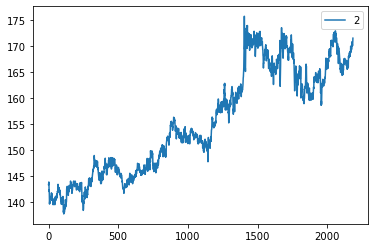

In [21]:
sp500.plot.line(y=CLOSE, use_index=True)

In [22]:
del sp500[TURNOVER]

In [23]:
sp500["Tomorrow"] = sp500[CLOSE].shift(-1)

In [24]:
sp500["Target"] = (sp500["Tomorrow"] > sp500[CLOSE]).astype(int)

In [25]:
#sp500 = sp500.loc["1990-01-01":].copy()

In [26]:
TIME = 0
OPEN = 1
CLOSE = 2
HIGH= 3
LOW = 4
VOLUME = 5
TURNOVER = 6

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = [CLOSE, VOLUME, OPEN, HIGH, LOW]

model.fit(train[predictors], train["Target"])

KeyError: "None of [Index(['Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')] are in the [columns]"

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47058823529411764

<AxesSubplot:xlabel='Date'>

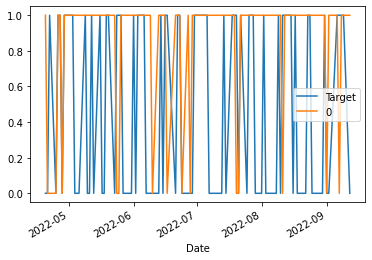

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

0    3337
1    2401
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.534777176176593

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.536075
0    0.463925
Name: Target, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [ ]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1,0.997948,0.0,0.989893,1.0,0.982136,26.0,0.902791,120.0,1.103594,542.0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,4006.179932,1,1.009087,1.0,1.008370,2.0,0.999819,27.0,0.919786,121.0,1.123489,543.0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,4067.360107,1,1.003294,2.0,1.012411,3.0,1.005349,28.0,0.926253,122.0,1.130564,543.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

0.0    3933
1.0     805
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5701863354037268

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.546855
0    0.453145
Name: Target, dtype: float64

In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14,0,0.0
2003-11-17,0,1.0
2003-11-18,1,1.0
2003-11-19,0,0.0
2003-11-20,1,1.0
...,...,...
2022-09-06,1,0.0
2022-09-07,1,0.0
2022-09-08,1,0.0
